# Simulating Noise On Amazon Braket

In this hands-on lab, we show you how you can simulate the effect of noise on your circuits.

This notebook in intended to help you get started. Additional learning material can be found in the [Amazon Braket Examples GitHub repository](https://github.com/aws/amazon-braket-examples/tree/main): 
* `Braket examples/braket_features/Simulating_Noise_On_Amazon_Braket.ipynb` provides a more detailed overview of noise simulations on Amazon Braket
* `Braket examples/braket_features/Noise_models/Noise_models_on_Amazon_Braket.ipynb` introduces noise models on Amazon Braket
* `Braket examples/braket_features/Noise_models/Noise_models_on_Rigetti.ipynb` shows you how to construct a noise model from device calibration data for real quantum processing units

In [2]:
# general imports
import string
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Braket SDK module imports
from braket.circuits import Circuit, Gate, Instruction, Observable
from braket.devices import LocalSimulator, Devices
from braket.aws import AwsDevice, AwsQuantumTask

## Build an Example Circuit

First, we build a [GHZ](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) circuit with a parametrized subroutine.


In [3]:
# function to build a GHZ state
def ghz(n_qubits):
    """
    function to return a GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()

    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit


# register the subroutine
Circuit.register_subroutine(ghz)

Let's create an instance of a 3-qubit GHZ circuit.

In [4]:
# create the circuit
n_qubits = 3
ghz = Circuit().ghz(n_qubits)

print(ghz)

T  : │  0  │  1  │  2  │
      ┌───┐             
q0 : ─┤ H ├───●─────────
      └───┘   │         
            ┌─┴─┐       
q1 : ───────┤ X ├───●───
            └───┘   │   
                  ┌─┴─┐ 
q2 : ─────────────┤ X ├─
                  └───┘ 
T  : │  0  │  1  │  2  │


## Simulate the Circuit without Noise

First, we review the results we expect for executing the circuit in a noise-free environment.

In [5]:
# set up device: Local Simulator
device = LocalSimulator()

In [6]:
# run circuit
result = device.run(ghz, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

Counter({'000': 506, '111': 494})


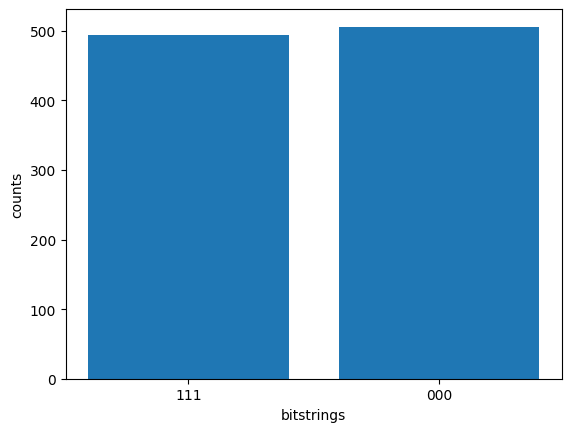

In [7]:
# plot using Counter
plt.bar(counts.keys(), counts.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.draw()

## Execute the Circuit on a real QPU

Now, let's run the same circuit on a real QPU and compare the results with the above simulation.

In [12]:
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2")

In [13]:
rigetti_task = rigetti.run(ghz, shots=1000)
print(rigetti_task)

AwsQuantumTask('id/taskArn':'arn:aws:braket:us-west-1:013288819788:quantum-task/e70f4aa2-87fd-40fd-bf1a-5dde760a5620')


In [14]:
# check status
print('Status of task:', rigetti_task.state())

Status of task: QUEUED


Status of (reconstructed) task: COMPLETED


1000 shots taken on machine arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-2.

The compiled circuit is:
 PRAGMA INITIAL_REWIRING "NAIVE"
DECLARE ro BIT[3]
PRAGMA PRESERVE_BLOCK
RX(1.5707963267948966) 82
RZ(3.141592653589793) 82
ISWAP 82 75
RZ(1.5707963267948966) 82
RX(1.5707963267948966) 82
RZ(4.71238898038469) 82
ISWAP 82 75
RZ(3.141592653589793) 75
RX(1.5707963267948966) 75
RZ(4.71238898038469) 75
ISWAP 75 76
RZ(1.5707963267948966) 75
RX(1.5707963267948966) 75
RZ(4.71238898038469) 75
ISWAP 75 76
RZ(3.141592653589793) 76
RX(1.5707963267948966) 76
PRAGMA END_PRESERVE_BLOCK
MEASURE 82 ro[0]
MEASURE 75 ro[1]
MEASURE 76 ro[2]
Measurement counts: Counter({'000': 501, '111': 343, '110': 35, '101': 33, '001': 28, '100': 28, '011': 22, '010': 10})


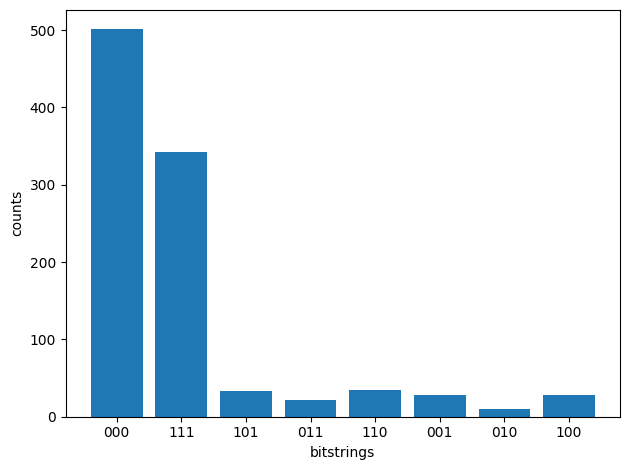

In [28]:
# retrieve task
task = rigetti_task
#task = AwsQuantumTask(arn='')

# print status
status = task.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task.result()

    # get all metadata of submitted task
    metadata = task.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))

    # get the compiled circuit
    print("The compiled circuit is:\n", results.additional_metadata.rigettiMetadata.compiledProgram)

    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.draw()
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message
    print('Your task is in terminal status, but has not completed.')
else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

## Add Noise to our simulation

Building on the knowledge you already have, create another GHZ circuit with 3 qubits - but this time, let's add a noise channel to it.

For that purpose, we need to import the Noise library from Braket SDK.

In [16]:
from braket.circuits import Noise

In [17]:
# define a GHZ circuit using previous function
n_qubits = 3
ghz_with_noise = Circuit().ghz(n_qubits)

To add bit flip noise with a 10% of probabilty to happen in all gate operations in the circuit, we need to call the `Noise` object with the `BitFlip` method and the correct parameter. Then we can apply the noise channel to the circuit by calling the method `apply_gate_noise`:

In [18]:
# define a noise channel
noise = Noise.BitFlip(probability=0.10)

# add noise to every gate in the circuit
ghz_with_noise.apply_gate_noise(noise)

print(ghz)

T  : │  0  │  1  │  2  │
      ┌───┐             
q0 : ─┤ H ├───●─────────
      └───┘   │         
            ┌─┴─┐       
q1 : ───────┤ X ├───●───
            └───┘   │   
                  ┌─┴─┐ 
q2 : ─────────────┤ X ├─
                  └───┘ 
T  : │  0  │  1  │  2  │


Now, we need to instantiate a noise simulator. We can choose between the local simulator and the DM1 on-demand simulator.

In [19]:
# select the Local Simulator and pass the noise parameter "braket_dm"
device = LocalSimulator("braket_dm")

# select the on-demand density matrix simulator DM1
#device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/dm1")

Now we just need to execute the circuit like any other (noise-free) circuit, and plot your results:

In [20]:
# run the circuit
task = device.run(ghz_with_noise, shots=1000)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print('measurement results:', measurement)

measurement results: Counter({'000': 357, '111': 316, '011': 77, '100': 77, '101': 46, '010': 45, '001': 42, '110': 40})


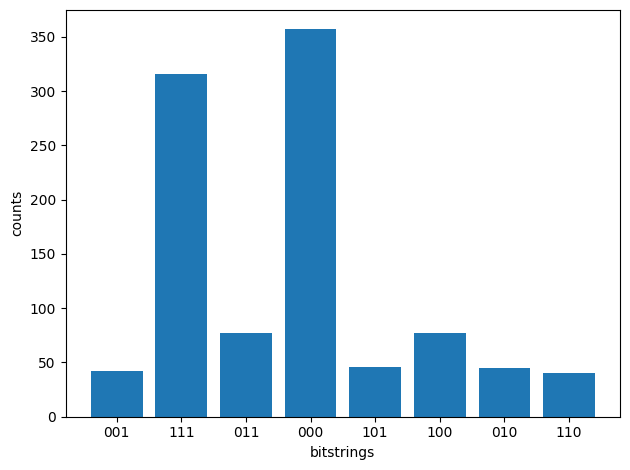

In [21]:
plt.bar(measurement.keys(), measurement.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.tight_layout()
plt.draw()

<div class="alert alert-block alert-info">
    How do the results from the QPU and DM1 compare? Did you get similar results? If not, why do you think that could be? </br>
    <b>Taking it further: </b> Explore more noise channels. Change the previous circuit to add a depolarizing noise channel at 0.05 probability. <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html#noise-simulation"> More examples here. </a> 
</div>

## Other Ways to Add Noise Channels to your Circuits

Instead of adding a noise channel globally to all logic operations in your circuit, the SDK provides options to model noise more fine-grained.

Let's start again creating a 5-qubit GHZ circuit instance.

In [22]:
my_circuit = Circuit().ghz(5)
print(my_circuit)

T  : │  0  │  1  │  2  │  3  │  4  │
      ┌───┐                         
q0 : ─┤ H ├───●─────────────────────
      └───┘   │                     
            ┌─┴─┐                   
q1 : ───────┤ X ├───●───────────────
            └───┘   │               
                  ┌─┴─┐             
q2 : ─────────────┤ X ├───●─────────
                  └───┘   │         
                        ┌─┴─┐       
q3 : ───────────────────┤ X ├───●───
                        └───┘   │   
                              ┌─┴─┐ 
q4 : ─────────────────────────┤ X ├─
                              └───┘ 
T  : │  0  │  1  │  2  │  3  │  4  │


Now, let's add the bit flip noise channel only to the CNOT gates in our circuit:

In [23]:
my_circuit.apply_gate_noise(Noise.BitFlip(probability=0.1), target_gates=[Gate.CNot])
print(my_circuit)

T  : │  0  │        1        │        2        │        3        │        4        │
      ┌───┐       ┌─────────┐                                                       
q0 : ─┤ H ├───●───┤ BF(0.1) ├───────────────────────────────────────────────────────
      └───┘   │   └─────────┘                                                       
            ┌─┴─┐ ┌─────────┐       ┌─────────┐                                     
q1 : ───────┤ X ├─┤ BF(0.1) ├───●───┤ BF(0.1) ├─────────────────────────────────────
            └───┘ └─────────┘   │   └─────────┘                                     
                              ┌─┴─┐ ┌─────────┐       ┌─────────┐                   
q2 : ─────────────────────────┤ X ├─┤ BF(0.1) ├───●───┤ BF(0.1) ├───────────────────
                              └───┘ └─────────┘   │   └─────────┘                   
                                                ┌─┴─┐ ┌─────────┐       ┌─────────┐ 
q3 : ───────────────────────────────────────────┤ X ├─┤ BF(0.1) ├

In addition, let's assume we want to had a depolarizing noise channel to the gates acting on the qubits `q0` and `q2`:

In [24]:
my_circuit.apply_gate_noise(Noise.Depolarizing(probability=0.1), target_qubits=[0, 2])
print(my_circuit)

T  : │         0         │               1               │               2               │               3               │        4        │
      ┌───┐ ┌───────────┐       ┌───────────┐ ┌─────────┐                                                                                   
q0 : ─┤ H ├─┤ DEPO(0.1) ├───●───┤ DEPO(0.1) ├─┤ BF(0.1) ├───────────────────────────────────────────────────────────────────────────────────
      └───┘ └───────────┘   │   └───────────┘ └─────────┘                                                                                   
                          ┌─┴─┐  ┌─────────┐                     ┌─────────┐                                                                
q1 : ─────────────────────┤ X ├──┤ BF(0.1) ├────────────────●────┤ BF(0.1) ├────────────────────────────────────────────────────────────────
                          └───┘  └─────────┘                │    └─────────┘                                                                
             

Also, we can simulate noise becoming effective during qubit initialization and readout:

In [25]:
my_circuit.apply_initialization_noise(Noise.GeneralizedAmplitudeDamping(probability=0.05, gamma=0.1))

my_circuit.apply_readout_noise(Noise.PhaseFlip(probability=0.1))

print(my_circuit)

T  : │                  0                  │               1               │               2               │               3               │                 4                 │
      ┌───────────────┐ ┌───┐ ┌───────────┐       ┌───────────┐ ┌─────────┐                                                                 ┌─────────┐                         
q0 : ─┤ GAD(0.1,0.05) ├─┤ H ├─┤ DEPO(0.1) ├───●───┤ DEPO(0.1) ├─┤ BF(0.1) ├─────────────────────────────────────────────────────────────────┤ PF(0.1) ├─────────────────────────
      └───────────────┘ └───┘ └───────────┘   │   └───────────┘ └─────────┘                                                                 └─────────┘                         
      ┌───────────────┐                     ┌─┴─┐  ┌─────────┐                     ┌─────────┐                                              ┌─────────┐                         
q1 : ─┤ GAD(0.1,0.05) ├─────────────────────┤ X ├──┤ BF(0.1) ├────────────────●────┤ BF(0.1) ├─────────────────────

And finally, we can a noise channels bottom-up like a logic gate acting on a specific qubit at a specific position in the sequence of gates:

In [26]:
my_circuit.pauli_channel(2, probX=0.1, probY=0.2, probZ=0.3)
print(my_circuit)

T  : │                  0                  │               1               │               2               │                         3                         │                 4                 │
      ┌───────────────┐ ┌───┐ ┌───────────┐       ┌───────────┐ ┌─────────┐                                                                                     ┌─────────┐                         
q0 : ─┤ GAD(0.1,0.05) ├─┤ H ├─┤ DEPO(0.1) ├───●───┤ DEPO(0.1) ├─┤ BF(0.1) ├─────────────────────────────────────────────────────────────────────────────────────┤ PF(0.1) ├─────────────────────────
      └───────────────┘ └───┘ └───────────┘   │   └───────────┘ └─────────┘                                                                                     └─────────┘                         
      ┌───────────────┐                     ┌─┴─┐  ┌─────────┐                     ┌─────────┐                                                                  ┌─────────┐                         
q1 : ─┤ GAD(0.1

Now, let's simulate this circuit:

Counter({'11111': 105, '00000': 100, '00100': 60, '01111': 56, '00111': 56, '10000': 52, '11000': 49, '11011': 48, '00011': 40, '11100': 32, '01000': 28, '10111': 28, '00001': 26, '11101': 26, '01011': 26, '10011': 25, '10100': 25, '11010': 23, '00010': 21, '11110': 21, '00101': 18, '11001': 18, '01100': 17, '00110': 15, '01101': 13, '01001': 13, '10001': 12, '10101': 11, '01010': 10, '10010': 10, '10110': 9, '01110': 7})


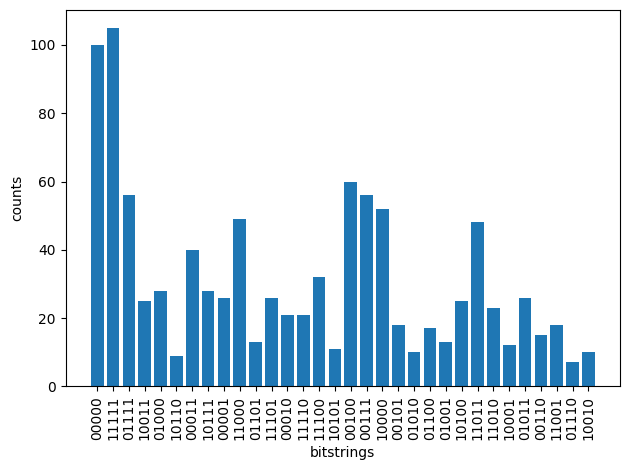

In [27]:
task = device.run(my_circuit, shots=1000)

# visualize the results
result = task.result()
measurement = result.measurement_counts
print(measurement)

plt.bar(measurement.keys(), measurement.values())
plt.xlabel('bitstrings')
plt.ylabel('counts')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.draw()